In [2]:
"""
This notebook is the lower bound that we need to beat.
"""

'\nThis notebook is the lower bound that we need to beat.\n'

In [3]:
import json
import os
import sys
import numpy as np
sys.path.append(os.path.abspath("../../.."))   # one level up from notebook/
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict



In [4]:
# read json file 
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_APG_on.json', 'r') as f:
    reconst_losses = json.load(f)

In [5]:

losses = defaultdict(lambda: {"lpips": [], "dino": []})

for item in reconst_losses:
    k = item["k_value"]
    losses[k]["lpips"].append(item["LPIPS"])
    losses[k]["dino"].append(item["DINOv2FeatureLoss"])


In [6]:
all_lpips = [v for k in losses for v in losses[k]["lpips"]]
all_dino  = [v for k in losses for v in losses[k]["dino"]]

min_loss_LPIPS = min(all_lpips)
max_loss_LPIPS = max(all_lpips)

min_loss_DINO  = min(all_dino)
max_loss_DINO  = max(all_dino)

print("LPIPS Loss range:", min_loss_LPIPS, "to", max_loss_LPIPS)
print("DINOV2Feature Loss range:", min_loss_DINO, "to", max_loss_DINO)


LPIPS Loss range: 0.020792722702026367 to 1.0791053771972656
DINOV2Feature Loss range: 0.010271608829498291 to 1.1576836109161377


In [7]:
import numpy as np

print("LPIPS Loss statistics per token count:")
for k in sorted(losses):
    lpips_vals = np.array(losses[k]["lpips"])
    print(f"k={k}: mean={lpips_vals.mean():.3f}, std={lpips_vals.std():.3f}")

print("\nDINOV2 Feature Loss statistics per token count:")
for k in sorted(losses):
    dino_vals = np.array(losses[k]["dino"])
    print(f"k={k}: mean={dino_vals.mean():.3f}, std={dino_vals.std():.3f}")


LPIPS Loss statistics per token count:
k=1: mean=0.664, std=0.061
k=2: mean=0.639, std=0.066
k=4: mean=0.581, std=0.073
k=8: mean=0.541, std=0.076
k=16: mean=0.504, std=0.080
k=32: mean=0.462, std=0.081
k=64: mean=0.426, std=0.081
k=128: mean=0.378, std=0.079
k=256: mean=0.325, std=0.076

DINOV2 Feature Loss statistics per token count:
k=1: mean=0.602, std=0.270
k=2: mean=0.524, std=0.256
k=4: mean=0.470, std=0.250
k=8: mean=0.379, std=0.220
k=16: mean=0.331, std=0.198
k=32: mean=0.286, std=0.178
k=64: mean=0.255, std=0.164
k=128: mean=0.227, std=0.149
k=256: mean=0.191, std=0.128


In [8]:
# in order to make a fair comparison, filter the reconstruction losses to only those
# that have their densities available in our dataset
filtered_reconst_losses = [
    rec for rec in reconst_losses
    if 'image_id' in rec and int(rec['image_id']) < 40000
]

In [9]:
from data.utils.dataloaders import clean_ReconstructionDataset_Heuristic


ds = clean_ReconstructionDataset_Heuristic(
    reconstruction_data=filtered_reconst_losses,  # or your processed list of dicts
    error_key=["LPIPS"],
)

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

baseline_results = {}
for k in k_values:
    densities = []
    lids = []
    y = []

    for dp in ds:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
    
    if len(y) < 5:
        continue

    y = np.array(y)

    # -------------------------
    # Baseline: predict mean(y)
    # -------------------------
    y_base = np.full_like(y, y.mean())
    mae_base  = mean_absolute_error(y, y_base)
    baseline_results[k] = mae_base

    print(f"k={k}: Baseline MAE: {mae_base:.4f}")


k=1: Baseline MAE: 0.0441
k=2: Baseline MAE: 0.0475
k=4: Baseline MAE: 0.0534
k=8: Baseline MAE: 0.0570
k=16: Baseline MAE: 0.0600
k=32: Baseline MAE: 0.0612
k=64: Baseline MAE: 0.0618
k=128: Baseline MAE: 0.0610
k=256: Baseline MAE: 0.0591


In [11]:
best_lids = [26,26,25,25,24,24,23,14,14]
best_lids_per_k = {}
for best_lid, k in zip(best_lids, k_values):
    LID_JSON   = f"/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/original_images/val/t_{best_lid}/lid_0000_3125.json"
    # Load LID values; we assume it's ordered so that index i corresponds to image i
    with open(LID_JSON, 'r') as f:
        lid_values = json.load(f)
    best_lids_per_k[k] = lid_values

print('Sizes:', {k: len(v) for k, v in best_lids_per_k.items()})

Sizes: {1: 50000, 2: 50000, 4: 50000, 8: 50000, 16: 50000, 32: 50000, 64: 50000, 128: 50000, 256: 50000}


In [12]:
# load densities
main_folder = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/clean/list_version/val_density_div_list_reconst_"
k_values = [1,2,4,8,16,32,64,128,256]

density_dict = {}
for k in k_values:
    with open((main_folder + f"{k}/token_count/256_0000_0200.json"), 'r') as f:
        current_densities = json.load(f)
    density_dict[k]=current_densities

print(density_dict.keys(), len(density_dict[1]), len(density_dict[2]), len(density_dict[4]), len(density_dict[8]), len(density_dict[16]), len(density_dict[32]), len(density_dict[64]), len(density_dict[128]), len(density_dict[256]))

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256]) 4000 4000 4000 4000 4000 4000 4000 4000 4000


In [13]:
processed_density_dict = {}
timestep_needed = [0,0,0,0,0,0,0,3,4]
for idx, (key, value) in enumerate(density_dict.items()):
    processed_density_dict[key] = [sum(v[0][timestep_needed[idx]:]) for v in value]

print(processed_density_dict.keys(), len(processed_density_dict[1]), len(processed_density_dict[2]), processed_density_dict[1][1])

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256]) 4000 4000 29421.284240722656


In [14]:
max_available = len(density_dict[1])  # max available
print("Max available densities:", max_available)
# in order to make a fair comparison, filter the reconstruction losses to only those
# that have their densities available in our dataset
filtered_reconst_losses = [
    rec for rec in reconst_losses
    if 'image_id' in rec and int(rec['image_id']) < max_available
]

Max available densities: 4000


In [15]:
print(processed_density_dict.keys())
ds = clean_ReconstructionDataset_Heuristic(
    reconstruction_data=filtered_reconst_losses,  # or your processed list of dicts
    local_density_information=processed_density_dict, # [l[0] for l in density]
    lid_information=best_lids_per_k,
    error_key=["LPIPS"],
)

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256])


In [16]:
from sklearn.linear_model import LinearRegression


heuristic_results = {}
for k in k_values:
    densities = []
    lids = []
    y = []
    for dp in ds:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            densities.append(dp["local_density"])
            lids.append(dp["lid"])
            
    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))
        continue

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.stack([densities, lids], axis=1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0519, R²=0.021
k=2: Heuristic method  MAE=0.0510, R²=0.068
k=4: Heuristic method  MAE=0.0459, R²=0.296
k=8: Heuristic method  MAE=0.0441, R²=0.401
k=16: Heuristic method  MAE=0.0429, R²=0.498
k=32: Heuristic method  MAE=0.0398, R²=0.584
k=64: Heuristic method  MAE=0.0373, R²=0.650
k=128: Heuristic method  MAE=0.0332, R²=0.721
k=256: Heuristic method  MAE=0.0278, R²=0.795


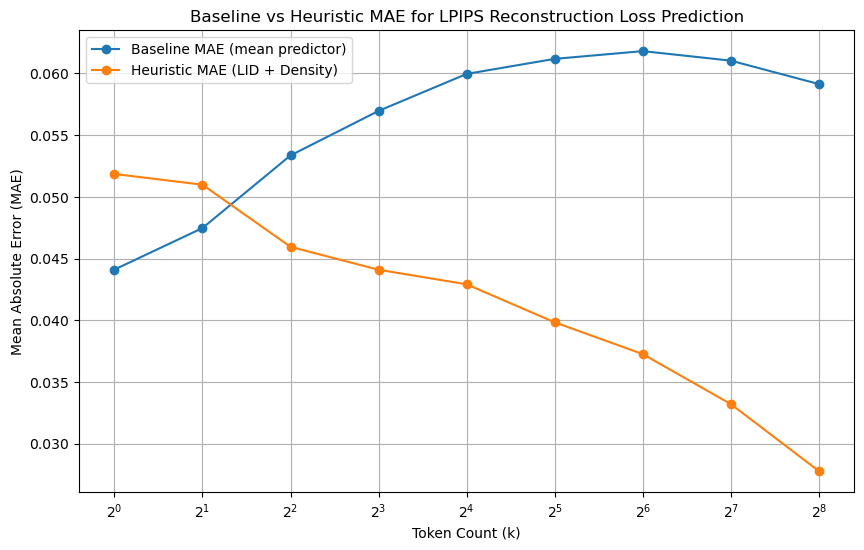

In [17]:
# plot baseline vs heuristic
ks = sorted(baseline_results.keys())
baseline_maes = [baseline_results[k] for k in ks]
heuristic_maes = [heuristic_results[k] for k in ks]
plt.figure(figsize=(10,6))
plt.plot(ks, baseline_maes, marker='o', label='Baseline MAE (mean predictor)')
plt.plot(ks, heuristic_maes, marker='o', label='Heuristic MAE (LID + Density)')
plt.xscale('log', base=2)
plt.xlabel('Token Count (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Baseline vs Heuristic MAE for LPIPS Reconstruction Loss Prediction')
plt.legend()
plt.grid(True)
plt.show()